In [1]:
# cd /Users/beyzaaygun/Desktop/Bioinformatic/EV/2023-2024/python
#!mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [ ]:
import pandas as pd
import scanpy as sc

In [7]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 pynndescent==0.5.12


In [8]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

In [9]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... writing an h5ad cache file to speedup reading next time


In [10]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [11]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


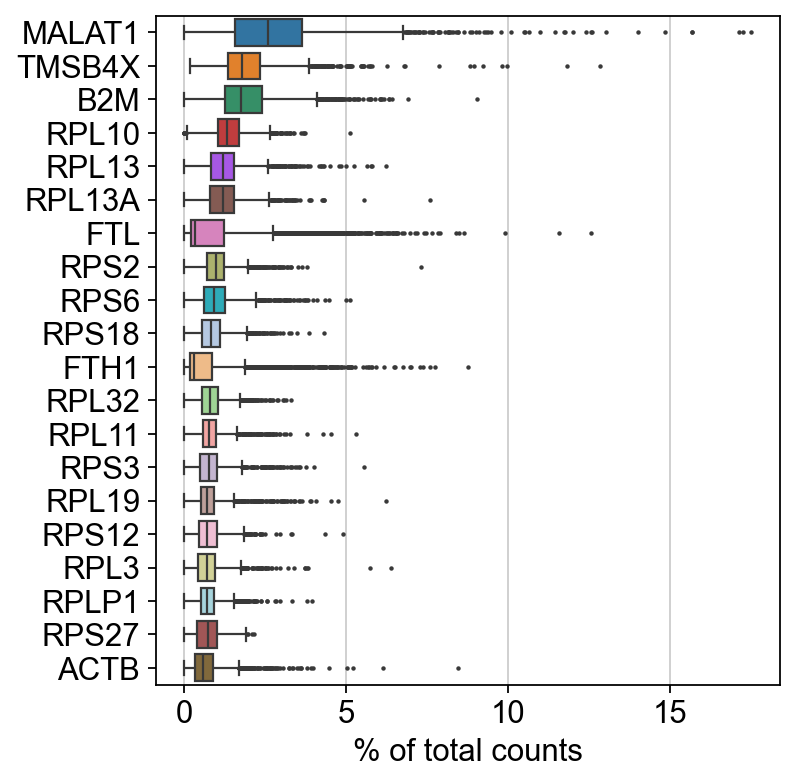

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [14]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [17]:
sc.pp.log1p(adata)

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [19]:
adata.raw = adata

In [20]:
adata = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

In [22]:
sc.pp.scale(adata, max_value=10)

In [39]:
count_matrix = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

# Sonucu gösterelim
print(count_matrix)

                   TNFRSF4    CPSF3L    ATAD3C   C1orf86      RER1  TNFRSF25  \
AAACATACAACCAC-1 -0.171470 -0.280812 -0.046677 -0.475169 -0.544024  4.928497   
AAACATTGAGCTAC-1 -0.214582 -0.372653 -0.054804 -0.683391  0.633951 -0.334837   
AAACATTGATCAGC-1 -0.376888 -0.295085 -0.057527 -0.520972  1.332648 -0.309362   
AAACCGTGCTTCCG-1 -0.285241 -0.281735 -0.052227 -0.484929  1.572679 -0.271825   
AAACCGTGTATGCG-1 -0.256484 -0.220394 -0.046800 -0.345859 -0.333409 -0.208122   
...                    ...       ...       ...       ...       ...       ...   
TTTCGAACTCTCAT-1 -0.290368  2.638307 -0.054510 -0.554384 -0.666646 -0.301333   
TTTCTACTGAGGCA-1 -0.386344  2.652699 -0.058686 -0.545443  1.201866 -0.321670   
TTTCTACTTCCTCG-1 -0.207090 -0.250464 -0.046397 -0.409737  2.193954 -0.221747   
TTTGCATGAGAGGC-1 -0.190328 -0.226334 -0.043999 -0.354661 -0.350005 -0.195177   
TTTGCATGCCTCAC-1 -0.333789 -0.253588 -0.052716 -0.425292 -0.457937  5.322872   

                   TNFRSF9  CTNNBIP1   

In [ ]:
# İstenen gen listesi
istenilen_genler = ["CD63", "CD81", "CHMP1A", "CHMP1B", "CHMP2A", "CHMP2B", "CHMP3", "CHMP4B", "CHMP4C", "CHMP5", "CHMP6", "HGS", "HSPA4", "HSPA8", "HSPD1", "MVB12B", "PDCD6", "PDCD6IP", "SDCBP", "SNF8", "STAM", "STAM2", "TSG101", "VPS36", "VPS37A", "VPS37B", "VPS37C", "VPS37D", "VPS4A", "VTA1"]


# İstenilen genlerin olduğu sütunları filtrele
filtered_count_matrix = count_matrix[istenilen_genler]

# Sonucu göster
print(filtered_count_matrix)

In [62]:
if "CD81" in count_matrix.columns:
    print("CD63 sütunu mevcut.")
else:
    print("CD63 sütunu mevcut değil.")

CD63 sütunu mevcut değil.


In [ ]:
from bioservices import HGNC

# HGNC nesnesini oluşturalım
hgnc = HGNC()

# İstenilen genler listesi
istenilen_genler = ["CD63", "CD81", "CHMP1A", "CHMP1B", "CHMP2A", "CHMP2B", "CHMP3", "CHMP4B", "CHMP4C", "CHMP5", "CHMP6", "HGS", "HSPA4", "HSPA8", "HSPD1", "MVB12B", "PDCD6", "PDCD6IP", "SDCBP", "SNF8", "STAM", "STAM2", "TSG101", "VPS36", "VPS37A", "VPS37B", "VPS37C", "VPS37D", "VPS4A", "VTA1"]

# Genlerin HGNC sembollerini alalım
for gen in istenilen_genler:
    hgnc_info = hgnc.search(gen)
    if hgnc_info:
        print(f"{gen}: {hgnc_info['name']}")
    else:
        print(f"{gen} için HGNC sembolü bulunamadı.")


In [61]:
pbmc = pd.read_csv('normalized_dataset.csv', index_col=0) 